# Recommnder System using Content Filtering

Datastet : TMBD5000 Movie Dataset on [Kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata)

# Table of Contents
1. [Introduction](#intro)<br />
    1.1 [Demographic](#demographic)<br />
    1.2 [Classification](#classification)<br />
    1.3 [Collaborative Filtering](#collab)<br />
    1.4 [TMDB5000 Dataset](#tmdb)<br />
2. [Data Wrangling](#dw)<br />
    2.1 [Removing `original_title`](#og_title)<br />
    2.2 [Sanitize `revenues`](#rev)<br />
    2.3 [Sanitize `budget`](#budget)<br />
    2.4 [Sanitize `year`](#year)<br />
    2.5 [Create new feature: `return`](#return)<br /> 
3. [Exploratory Data Analysis](#eda)<br />
    3.1 [Word Clouds](#wc)<br />
    3.2 [Languages](#lang)<br />
    3.3 [Metrics](#metrics)<br />
    3.4 [Release Dates](#release-date)<br />
    3.5 [Budget](#budget-eda)<br /> 
    3.6 [Revenue](#rev-eda)<br />
    3.7 [Genres](#genres-eda)<br />
4. [Modeling](#modeling)<br />
    4.1 [Recommendations based on Movie Blurb](#rec-ovw)<br />
    4.2 [Recommendations based on Movie Metadata](#rec-met)<br />

# Introduction

What are Recommendations Systems? Strictly speaking, Recommendations Systems (or RecSys as they are usually abbreviated) are a class of information filtering systems. Their goal is to improve the quality of results being delivered to the end user, by taking into account different heuristics related to the user itself.

Recommendation Systems power nearly every kind of content on the Internet, from search results on your favorite search engine to the `Customers Who Bought This Item Also Bought` window on [Amazon.com](http://rejoiner.com/resources/amazon-recommendations-secret-selling-online). [Netflix](https://help.netflix.com/en/node/100639) uses recommender systems to help you find the next show or movie to watch. They're everywhere and highly effective because of their ability to narrow down content for a user, be it a movie to watch or an item to buy. 

There are primarily three different kinds of RecSys, each of which is formulated differently and has different operating characteristics. 

<a id="demographic"/></a>
1.Demographic

Demographic(or popularity) based RecSys offer generalized recommendations. They offer non-personalized recommendations, instead focusing on what's universally popular(within the problem domain) and assuming that generality holds for all users from the target demography. They are simple and easy to get started with and don't require any kind of user data to be effective. That said, they're not as effective as others types of RecSys that we'll look at.

<a id="classification"/></a>
2.Content Based Filtering

Classification based RecSys try to group together similar items. If a user has seen or shopped from an item, they're more likely to be interested in other entities from the same bucket. Instead of relying on user information, they rely on information about the item itself to group similar items together in the same bucket. More information can be found [here](https://developers.google.com/machine-learning/recommendation/content-based/basics)

<a id="collab"/></a>
3.Collaborative Filtering

Collaborative Filtering adds to the idea of Content Based Filtering by using similarities between user data and item data to make recommendations. To put it simply, consider the following scenario: person A has seen movie X and person B has seen movie Y. Now, it turns out person A and B have similar tastes. So the system will then recommend movie Y to A accounting for that similarity. More information can be found here on the Google Developers [blog](https://developers.google.com/machine-learning/recommendation/collaborative/basics)

<a id="tmdb"/></a>
## TMDB5000 Dataset

TMDB5000 is a Kaggle hosted database derived from the TMDB API. You can learn more about TMDB on their [website](https://www.themoviedb.org/). It consists of roughly 5000 data entries, each of which has 20 features that we can work with. The data has probably gone through some amount of pre-processing steps, though there's a lot to be done, as we'll see below. 

Let's dive into some of the code, so we can get started.

In [1]:
#hide
#magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
#collapse-hide
#imports

from utils import build_word_cloud, clean_num, get_month, get_day, get_director, get_list, clean_list, create_feature
from pathlib import Path
import warnings
warnings.simplefilter('ignore')
import ast
import math
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
dataPath = Path('data/')
# print(dataPath.absolute())

In [6]:
movies = pd.read_csv(dataPath/'tmdb_5000_movies.csv')
credits = pd.read_csv(dataPath/'tmdb_5000_credits.csv')

In [7]:
movies.shape

(4803, 20)

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

We can see that we have data on 4803 different movies. The different features available include the budget, revenue of the movie, cast and crew as well as descriptive informatin about the genres and keywords.

Let's look at a few samples of the data, so we can get a sense of the work that we have to do before we can start extracting meaningful information.

In [9]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


<a id="dw" ></a>
# Data Wrangling

As can be seen above, several features are in a stringified format, so we'll need to convert those back to their original formats. There's a `homepage` feature which has no information present for a majority of the data points, so maybe we'll look into that as well.

Almost all of the features are represented as generic object dtypes, rather than native data types, so we'll look into that as well. We already have certain features, namely `vote_count`  and `vote_average` that we can use to gain some kind of insight and build a baseline recommendation system.

<a id="og_title"/></a>
## Removing `original_title` feature

We have two features related to the title/name in the movie, namely `title` and `original_title`. There are however, a small number of cases when those two features aren't exactly the same (~6%) of the total dataset. A visual inspection tells us even in those cases, we can get the name of the movie by looking at `title` and `original_language` features. 

Considering we're trying to build a recommender system, the name of the movie is going to be one of the lesser significant features and we can safely remove it from consideration.

In [10]:
cols = ['title', 'original_title', 'original_language']
movies[movies['original_title'] != movies['title']][cols].head()

,title,original_title,original_language
97,Shin Godzilla,シン・ゴジラ,ja
215,Fantastic 4: Rise of the Silver Surfer,4: Rise of the Silver Surfer,en
235,Asterix at the Olympic Games,Astérix aux Jeux Olympiques,fr
317,The Flowers of War,金陵十三釵,zh
474,Evolution,Évolution,fr


In [11]:
movies = movies.drop('original_title', axis = 1)

<a id="rev"/></a>
## Sanitizing the `revenue` feature

In [12]:
movies['revenue'].describe()

count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64

In [13]:
print(movies[movies['revenue'] == 0].shape[0]/(movies.shape[0]))

0.29710597543202166


We can see above that roughly 30% of the entries in our data have no `revenue` ie revenue is 0. While it may come across as a not so useful feature, we can use it later. For now, let's sanitize the zero values so we get some info out of it.

In [14]:
movies['revenue'] = movies['revenue'].replace(0, math.nan)

<a id="budget"/></a>
## Sanitizing the `budget` feature

In [15]:
movies['budget'].describe()

count    4.803000e+03
mean     2.904504e+07
std      4.072239e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [16]:
print(movies[movies['budget'] == 0].shape[0]/(movies.shape[0]))

0.21590672496356444


We can see above that roughly 22% of the entries in our data have no `budget` ie budget is 0. Let's sanitize the zero values, so we can use it later.

In [17]:
movies['budget'] = movies['budget'].replace(0, math.nan)

<a id="year"/></a>
## Sanitizing `year` feature

Let's sanitize the year column. Currently it's a generic object datatype, we'll convert it to a `datetime` representation

In [18]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(\
                lambda x: str(x).split('-')[0] if x != math.nan else math.nan)

<a id="return"/></a>
## Create new feature: `return`

The feature `return` will describe the Return On Investment(ROI) for a movie. It's simply a numeric value that describes the revenue in terms of multiples from the original budget (investment).

In [19]:
movies['return'] = movies['revenue'] / movies['budget']

In [20]:
movies['return'].describe()

count    3.229000e+03
mean     2.954822e+03
std      1.506101e+05
min      5.217391e-07
25%      1.022463e+00
50%      2.300366e+00
75%      4.420822e+00
max      8.500000e+06
Name: return, dtype: float64

There's a lot more cleaning and aggregation that needs to be done. But without exploring the data first, and getting some kind of intuition for the data, we don't really know what to do. We'll explore the data first, and do any kind of cleaning and generating features on the fly later as needed.

<a id="eda"/></a>
# EDA
Let's move on to do some exploratory data analysis, where we'll explore the dataset. 

<a id="wc"/></a>
## Word Clouds
We start by building world clouds, to get an idea of the titles and keywords for the dataset.

In [21]:
movies['title'] = movies['title'].astype('str')
movies['overview'] = movies['overview'].astype('str')

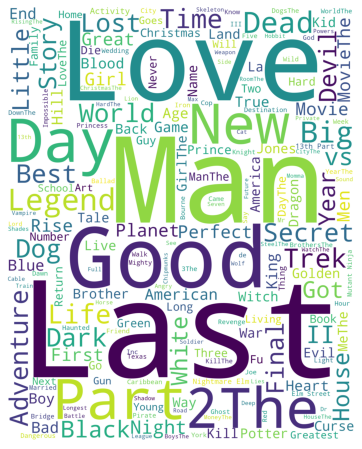

In [22]:
build_word_cloud(movies, 'title')

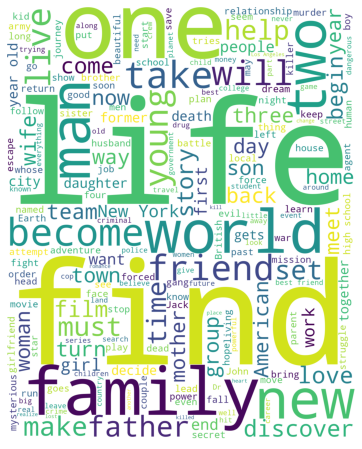

In [23]:
build_word_cloud(movies, 'overview')

<a id="lang"/></a>
## Languages

Let's look into the different languages of the movies available in the dataset. If I could take a guess, just from looking at the data, I'd say most of the movies are in English, with a sprinking of some French, Japanese and Asian movies.

In [24]:
movies['original_language'].drop_duplicates().shape

(37,)

There are 37 different languages, that's a wide range. Let's plot the occurence of each language

In [25]:
languages = pd.DataFrame(movies['original_language'].value_counts())
languages['language'] = languages.index
columns = ['count', 'language']
languages.columns = columns

In [26]:
languages.head(7)

,count,language
en,4505,en
fr,70,fr
es,32,es
de,27,de
zh,27,zh
hi,19,hi
ja,16,ja


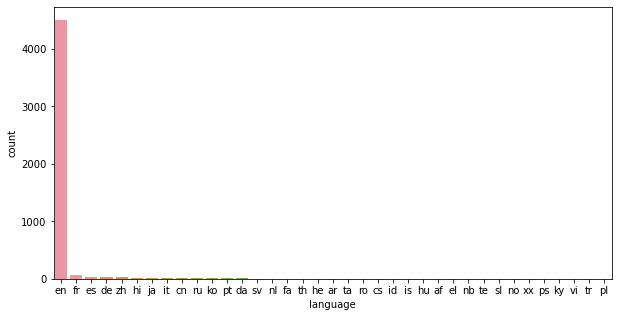

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'language', y = 'count', data = languages)
plt.show()

As expected, an overwhelmingly large number of the movies are in English. Let's look at a graph that makes it a bit easier for us to visualize the different languages present in the dataset.

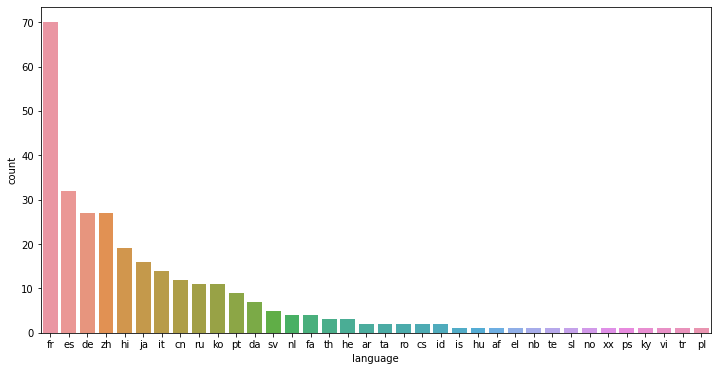

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(x = 'language', y = 'count', data = languages.iloc[1:])
plt.show()

<a id="metrics"/></a>
## Metrics

There are 3 fields in the dataset, which are hard metrics already given to us. They are `popularity`, `vote_count` and `vote_average`.

In [29]:
movies['popularity'] = movies['popularity'].apply(clean_num).astype('float')
movies['vote_count'] = movies['vote_count'].apply(clean_num).astype('float')
movies['vote_average'] = movies['vote_average'].apply(clean_num).astype('float')

In [30]:
#list movies by popularity
movies[['title', 'popularity']].sort_values('popularity', ascending = False)

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
...,...,...
4625,Midnight Cabaret,0.001389
4118,Hum To Mohabbat Karega,0.001186
4727,Penitentiary,0.001117
3361,Alien Zone,0.000372


In [31]:
movies[['title', 'vote_count']].sort_values('vote_count', ascending = False)

,title,vote_count
96,Inception,13752.0
65,The Dark Knight,12002.0
0,Avatar,11800.0
16,The Avengers,11776.0
788,Deadpool,10995.0
...,...,...
4210,Dil Jo Bhi Kahey...,0.0
4716,The Blood of My Brother: A Story of Death in Iraq,0.0
4569,Mutual Friends,0.0
4714,An American in Hollywood,0.0


In [32]:
movies[['title', 'vote_average']].sort_values('vote_average', ascending = False)

,title,vote_average
3519,Stiff Upper Lips,10.0
4247,Me You and Five Bucks,10.0
4045,"Dancer, Texas Pop. 81",10.0
4662,Little Big Top,10.0
3992,Sardaarji,9.5
...,...,...
3960,The Deported,0.0
4684,American Beast,0.0
3967,Four Single Fathers,0.0
4486,Naturally Native,0.0


<a id="release-date"/></a>
## Release Dates

Amongst all the features, we could be looking at or creating, perhaps few are as important as time of release. When a movie is released tends to have a strong correlation with how well it does. Major franchisee movies tend to be released around the time of holidays/summer months. Conversely, movies released around the time of holidays go on to do a lot better than those released around the year. Let's try to plot this distribution

In [33]:
movies['day'] = movies['release_date'].apply(get_day)
movies['month'] = movies['release_date'].apply(get_month)

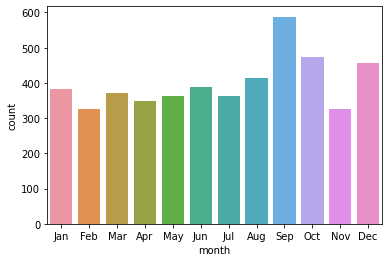

In [35]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.countplot(x = 'month', data = movies, order = months)

In [36]:
print(movies['revenue'].mean())

117031352.91587678


The mean revenue for movies in our dataset is 82260638.65167603. Let's now try to plot only the release dates of the movies whose revenue is greater than the mean for the data.

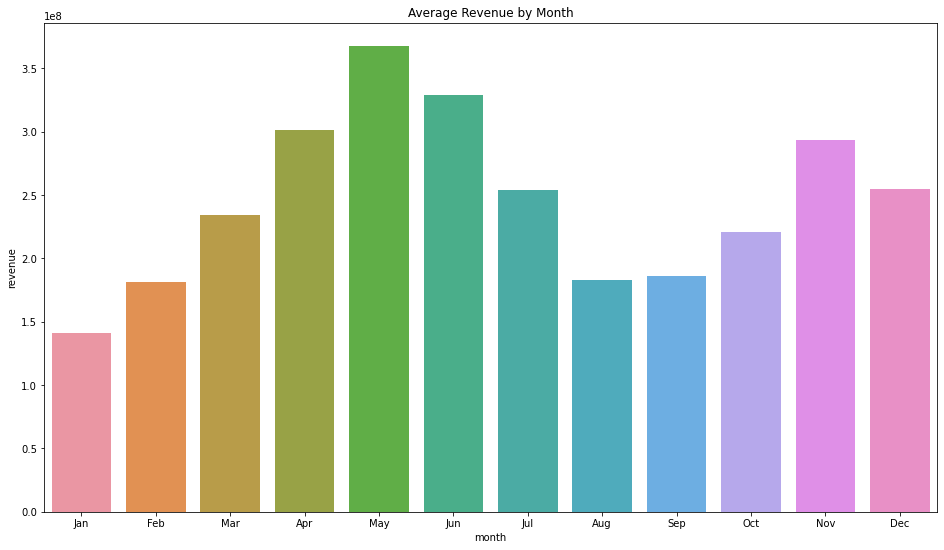

In [37]:
means = pd.DataFrame(movies[movies['revenue'] > 82260638.65167603].groupby('month')['revenue'].mean())
means['month'] = means.index
plt.figure(figsize=(16,9))
plt.title('Average Revenue by Month')
sns.barplot(x = 'month', y = 'revenue', data = means, order = months)

From the chart above, we can see that the summer months(April - June) have the most number of movies who fare better than the numerically average movie in the dataset. 

How similar/dissimilar is this chart from one where we graph all movies against the mean revenue?

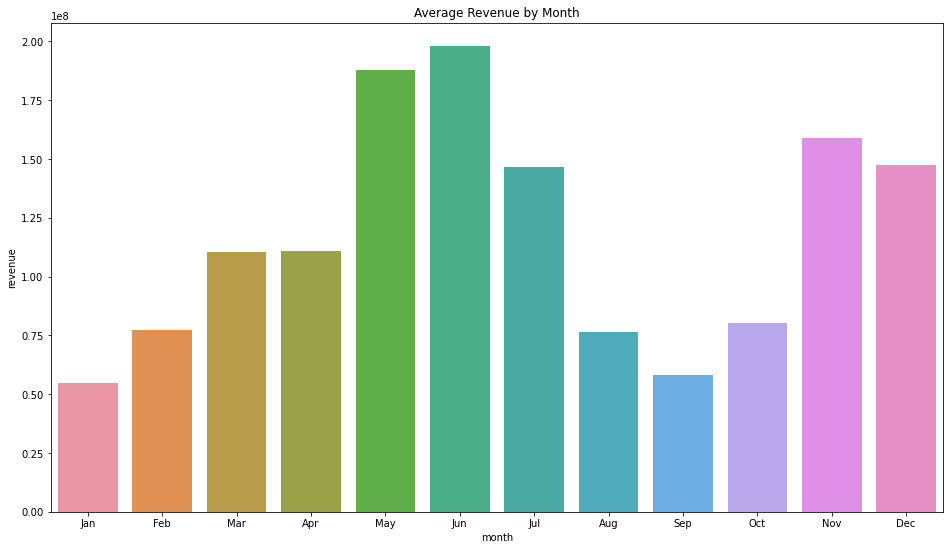

In [38]:
means = pd.DataFrame(movies[movies['revenue'] > 1].groupby('month')['revenue'].mean())
means['month'] = means.index
plt.figure(figsize=(16,9))
plt.title('Average Revenue by Month')
sns.barplot(x = 'month', y = 'revenue', data = means, order = months)

<a id="budget-eda"/></a>
## Budget

Is there a correlation between the budget of a movie and its return? 

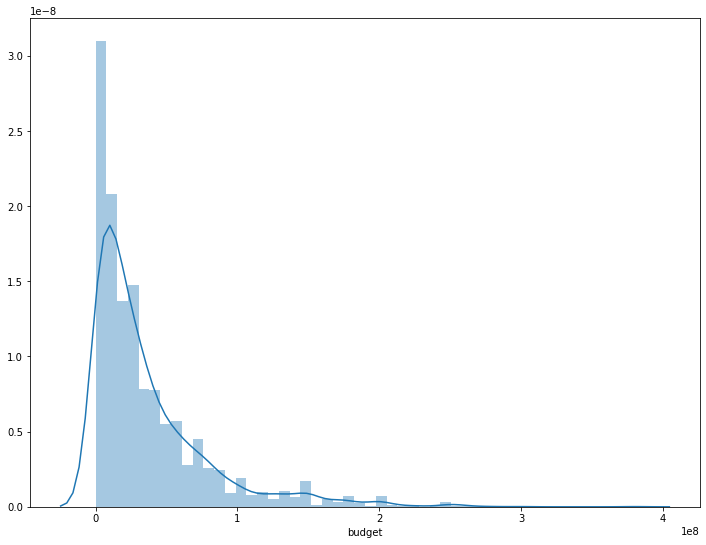

In [39]:
plt.figure(figsize=(12,9))
sns.distplot(movies[movies['budget'].notnull()]['budget'])

In [40]:
movies

,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,...,spoken_languages,status,tagline,title,vote_average,vote_count,year,return,day,month
0,237000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800.0,2009,11.763566,NaN,Dec
1,300000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500.0,2007,3.203333,NaN,May
2,245000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466.0,2015,3.594590,NaN,Oct
3,250000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106.0,2012,4.339756,NaN,Jul
4,260000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124.0,2012,1.092843,NaN,Mar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",...,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238.0,1992,9.276909,NaN,Sep
4799,9000.0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],...,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5.0,2011,NaN,NaN,Dec
4800,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English"

As we can see above, the budgets of the movies in the dataset are highly skewed , suggesting that a rather large number of movies have extremely small budgets

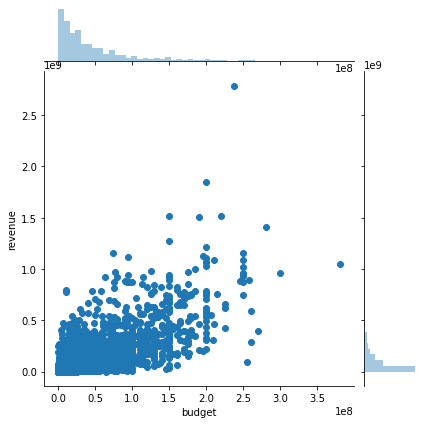

In [41]:
sns.jointplot(x = 'budget', y = 'revenue', data = movies)

The graph above suggests that there's a strong correlation between the budget of a movie and its revenue.

<a id="rev-eda"/></a>
## Revenue

In [42]:
movies['revenue'].describe()

count    3.376000e+03
mean     1.170314e+08
std      1.834831e+08
min      5.000000e+00
25%      1.535290e+07
50%      5.175184e+07
75%      1.401651e+08
max      2.787965e+09
Name: revenue, dtype: float64

In [43]:
best_revenue = movies[['title', 'budget', 'revenue']].sort_values('revenue', ascending = False)
best_revenue

,title,budget,revenue
0,Avatar,237000000.0,2.787965e+09
25,Titanic,200000000.0,1.845034e+09
16,The Avengers,220000000.0,1.519558e+09
28,Jurassic World,150000000.0,1.513529e+09
44,Furious 7,190000000.0,1.506249e+09
...,...,...,...
4797,Cavite,NaN,NaN
4799,Newlyweds,9000.0,NaN
4800,"Signed, Sealed, Delivered",NaN,NaN
4801,Shanghai Calling,NaN,NaN


A useful analysis that needs to be done here is to take inflation into account. The movies at the top are all from recent times, so maybe inflation analysis is something that's necessary to get meaningful information from this feature.

<a id="genres-eda"/></a>
## Genres

In [44]:
#convert string-ified lists to list representation
movies['genres'] = movies['genres'].fillna('[]').apply(
    ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [45]:
series = movies.apply(lambda x: pd.Series(x['genres']),axis = 1).stack().reset_index(level = 1, drop = True)
series.name = 'genres'

genres = movies.drop('genres', axis = 1).join(series)
genres['genres'].value_counts().shape[0]

20

There are 20 different genres, which we look at below

In [46]:
popular = pd.DataFrame(genres['genres'].value_counts()).reset_index()
popular.columns = ['genre', 'count']
popular.head()

,genre,count
0,Drama,2297
1,Comedy,1722
2,Thriller,1274
3,Action,1154
4,Romance,894


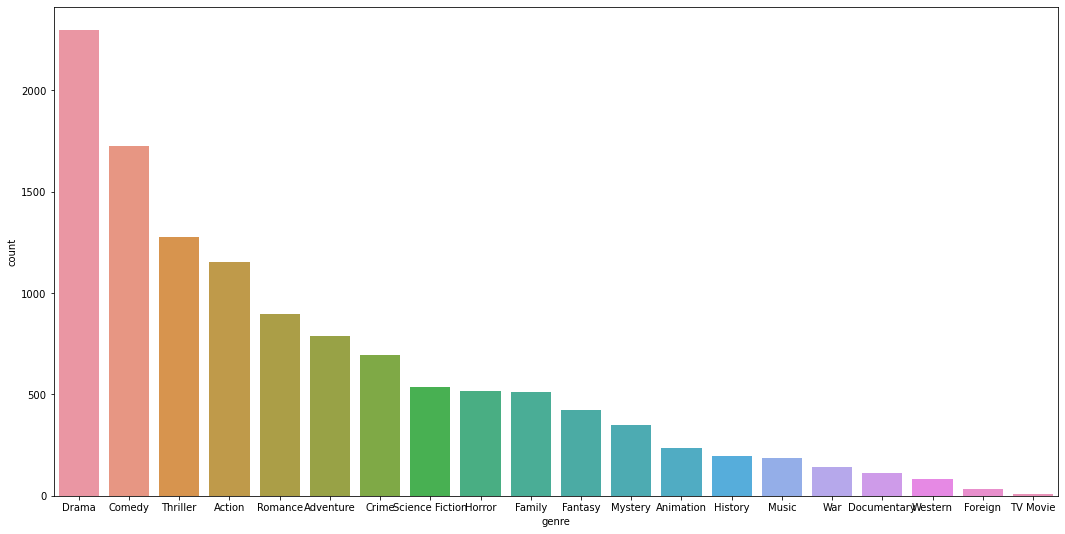

In [47]:
plt.figure(figsize = (18,9))
sns.barplot(x = 'genre', y = 'count', data = popular)
plt.show()

Let's look at the trends over time for a specific set of genres

In [48]:
genre = ['Drama', 'Action', 'Comedy', 'Thriller', 'Romance', 'Adventure', 'Horror', 'Family']

In [49]:
genres['year'] = genres['year'].replace('NaT', math.nan)
genres['year'] = genres['year'].apply(clean_num)

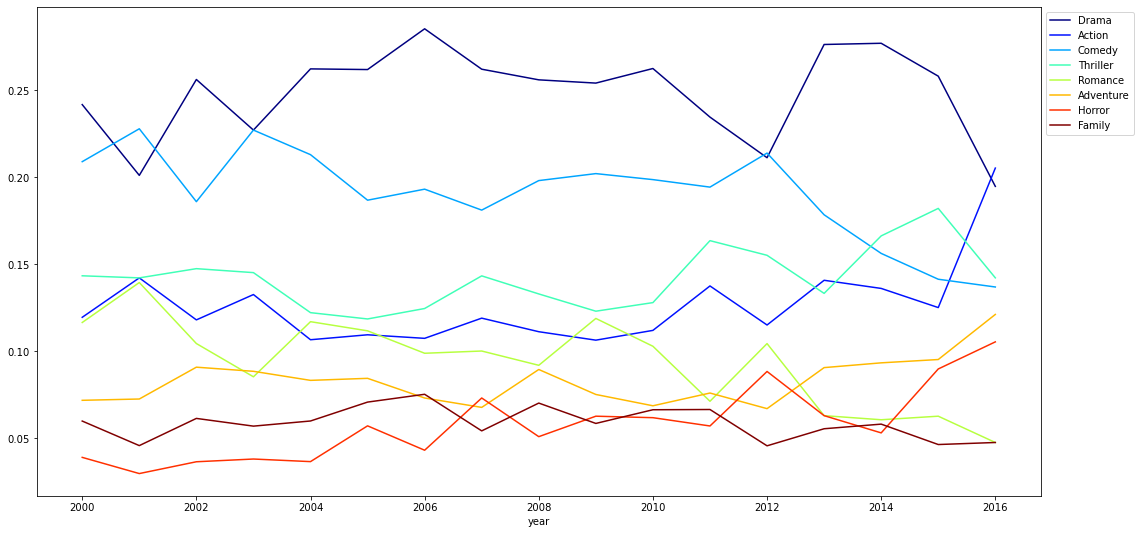

In [50]:
trends = genres[(genres['genres'].isin(genre)) & (genres['year'] >= 2000) & (genres['year'] <= 2016)]
ctab = pd.crosstab([trends['year']], trends['genres']).apply(lambda x: x/x.sum(), axis = 1)
ctab[genre].plot(kind = 'line', stacked = False, colormap = 'jet', figsize = (18,9))
plt.legend(bbox_to_anchor=(1, 1))

There seems to be a sharp decline in the number of `drama` movies from 2014-2016 while the number of movies under `horror` and `action` has gone up around the same time.

<a id="modeling"/></a>
# Modeling

There's a lot of interesting possibilities in terms of the viz that we could have done. Ideally, we will clean and analyze every possible feature and try to identify its importance towards the final task. However, for the purposes of keeping this clean and simple, I'll go ahead and build what we're actually here for: a recommendation system.

In [51]:
movies = pd.read_csv(dataPath/'tmdb_5000_movies.csv')
credits = pd.read_csv(dataPath/'tmdb_5000_credits.csv')

In [52]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [53]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


Join both the DataFrames on the `id` attribute, so we can incorporate features from both datasets.

In [54]:
credits.columns = ['id', 'title', 'cast', 'crew']
data = movies.merge(credits, on = 'id')

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

<a id="rec-ovw"/></a>
## Recommendations based on Movie Blurb

In the given data, the overview is a short blurb for the movie. We'll use this info to find other movies which have a similar description.

In [56]:
data['overview'] = data['overview'].fillna('')
overview = data['overview']

We'll convert each word in the overview to a word vector, so we can assign importance to each vector based on the number of occurences. This can be done using the TF-IDF Vectorizer. For more information, check out this [blog](https://monkeylearn.com/blog/what-is-tf-idf)

In [57]:
tfidf = TfidfVectorizer(stop_words = 'english')
mat = tfidf.fit_transform(overview)

In [58]:
# print(mat)

Here, `mat` is the matrix obtained from the TfidfVectorizer. The shape of the matrix indicates that there are 4803 movies, with a total of 20978 words being used to describe all the movies. For intuition, the matrix obtained is going to be a sparse matrix, with a score or each word for each movie if the word is present in the overview for the movie.

In [59]:
cosine_sim = cosine_similarity(mat, mat)

Now that we've obtained our matrix, next we need to determine, using the TF-IDF scores, which two movies are alike. There are several ways we can try to obtain this similarity, one of which is cosine similarity. 

Simply put, cosine similarity is the measure of distance between 2 vectors. It measure the cosine of the angle between the 2 vectors. The smaller the angle is, the more similar the 2 vectors are. It follows from trignometry that cos(0) is 1 and cos(90) is 0 ie. vectors that are parallel to each other are likely to be similar and vectors which are orthogonal are likely to be dissimilar.

Next, we'll do reverse indexing, so that if we are given a string representing a movie, we can get its id and index it in our dataset.

In [60]:
title2id = pd.Series(data.index, index = data['title_x'])
title2id.shape

(4803,)

In [61]:
def recommend(title, measure, npreds):
    idx = title2id[title]
    score = list(enumerate(measure[idx]))
    score = sorted(score, key = lambda x: x[1], reverse = True)
    score = score[:npreds]
    idxs = [i[0] for i in score]
    return data['title_x'].iloc[idxs]

In [62]:
recommend("Pirates of the Caribbean: At World's End", cosine_sim, 10)

1       Pirates of the Caribbean: At World's End
2542               What's Love Got to Do with It
3095                         My Blueberry Nights
2102                             The Descendants
1280                                   Disturbia
3632                        90 Minutes in Heaven
792                             Just Like Heaven
1709                Space Pirate Captain Harlock
1799                                Original Sin
2652                  Bathory: Countess of Blood
Name: title_x, dtype: object

In [63]:
recommend("El Mariachi", cosine_sim, 10)

4798                     El Mariachi
1701      Once Upon a Time in Mexico
3959    My Big Fat Independent Movie
3704                        Salvador
4769         The Legend of God's Gun
729                   A Civil Action
1965                       Footloose
324            The Road to El Dorado
3853                            2:13
421                           Zodiac
Name: title_x, dtype: object

In [64]:
recommend('The Dark Knight Rises', cosine_sim, 10)

3                         The Dark Knight Rises
65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
Name: title_x, dtype: object

<a id="rec-met"/></a>
## Recommendations based on metadata

We can also use the metadata of a given movie to get more relevant recommendations. For now, we'll focus on the cast and crew, genres and keyword features to generate recommendations which are similar to the input.

### Convert JSON to List

In [65]:
#parse stringified objects
pd.set_option('display.max_colwidth', 100)
features = ['keywords', 'genres', 'cast', 'crew']
for feature in features:
    data[feature] = data[feature].apply(ast.literal_eval)

In [66]:
data['director'] = data['crew'].apply(get_director)

In [67]:
data[['director', 'title_x']].head(5)

,director,title_x
0,James Cameron,Avatar
1,Gore Verbinski,Pirates of the Caribbean: At World's End
2,Sam Mendes,Spectre
3,Christopher Nolan,The Dark Knight Rises
4,Andrew Stanton,John Carter


In [68]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    data[feature] = data[feature].apply(get_list)

In [69]:
cols = ['title_x', 'director', 'cast', 'keywords', 'genres']
data[cols].head(3)

,title_x,director,cast,keywords,genres
0,Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang, Michelle Rodriguez]","[culture clash, future, space war, space colony, society]","[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley, Stellan Skarsgård, Chow Yun-fat]","[ocean, drug abuse, exotic island, east india trading company, love of one's life]","[Adventure, Fantasy, Action]"
2,Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux, Ralph Fiennes, Monica Bellucci]","[spy, based on novel, secret agent, sequel, mi6]","[Action, Adventure, Crime]"


In [70]:
for feature in features:
    data[feature] = data[feature].apply(clean_list)

In [71]:
data[cols].head(3)

,title_x,director,cast,keywords,genres
0,Avatar,James Cameron,"[samworthington, zoesaldana, sigourneyweaver, stephenlang, michellerodriguez]","[cultureclash, future, spacewar, spacecolony, society]","[action, adventure, fantasy, sciencefiction]"
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[johnnydepp, orlandobloom, keiraknightley, stellanskarsgård, chowyun-fat]","[ocean, drugabuse, exoticisland, eastindiatradingcompany, loveofone'slife]","[adventure, fantasy, action]"
2,Spectre,Sam Mendes,"[danielcraig, christophwaltz, léaseydoux, ralphfiennes, monicabellucci]","[spy, basedonnovel, secretagent, sequel, mi6]","[action, adventure, crime]"


In [72]:
data['feature'] = data.apply(create_feature, axis = 1)
cols = ['title_x', 'director', 'cast', 'keywords', 'genres', 'feature']
data[cols].head(3)

,title_x,director,cast,keywords,genres,feature
0,Avatar,James Cameron,"[samworthington, zoesaldana, sigourneyweaver, stephenlang, michellerodriguez]","[cultureclash, future, spacewar, spacecolony, society]","[action, adventure, fantasy, sciencefiction]",cultureclash future spacewar spacecolony society samworthington zoesaldana sigourneyweaver steph...
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[johnnydepp, orlandobloom, keiraknightley, stellanskarsgård, chowyun-fat]","[ocean, drugabuse, exoticisland, eastindiatradingcompany, loveofone'slife]","[adventure, fantasy, action]",ocean drugabuse exoticisland eastindiatradingcompany loveofone'slife johnnydepp orlandobloom kei...
2,Spectre,Sam Mendes,"[danielcraig, christophwaltz, léaseydoux, ralphfiennes, monicabellucci]","[spy, basedonnovel, secretagent, sequel, mi6]","[action, adventure, crime]",spy basedonnovel secretagent sequel mi6 danielcraig christophwaltz léaseydoux ralphfiennes monic...


In [73]:
count = CountVectorizer(stop_words = 'english')
count_mat = count.fit_transform(data['feature'])

In [74]:
cosine_sim1 = cosine_similarity(count_mat, count_mat)

In [75]:
data = data.reset_index()
idxs = pd.Series(data.index, index = data['title_x'])

In [76]:
recommend("Pirates of the Caribbean: At World's End", cosine_sim1, 10)

1                     Pirates of the Caribbean: At World's End
12                  Pirates of the Caribbean: Dead Man's Chest
199     Pirates of the Caribbean: The Curse of the Black Pearl
13                                             The Lone Ranger
5                                                 Spider-Man 3
30                                                Spider-Man 2
1652                                      Dragonball Evolution
17                 Pirates of the Caribbean: On Stranger Tides
115                                                    Hancock
129                                                       Thor
Name: title_x, dtype: object

In [77]:
recommend("El Mariachi", cosine_sim1, 10)

4798                     El Mariachi
1177                        Sin City
2229                   Machete Kills
3349                       Desperado
2181             From Dusk Till Dawn
880                       Grindhouse
669     Sin City: A Dame to Kill For
856                       Turbulence
2803                         Machete
1829          No Country for Old Men
Name: title_x, dtype: object

In [78]:
recommend('The Dark Knight Rises', cosine_sim1, 10)

3          The Dark Knight Rises
119                Batman Begins
65               The Dark Knight
1196                The Prestige
4638    Amidst the Devil's Wings
3332                 Harry Brown
4099                 Harsh Times
95                  Interstellar
1178               Vantage Point
2398                      Hitman
Name: title_x, dtype: object